# Import

In [3]:
import sys
sys.path.insert(0, '..')

import numpy as np
import mxnet as mx
from mxnet import gluon
from mxnet import nd
from mxnet.gluon import nn
from mxnet.gluon import Block, HybridBlock
from mxnet.gluon.model_zoo import vision
from mxnet import image
from mxnet import metric
from mxnet import init
from mxnet import gpu
from mxnet import autograd
import time
import os
import cv2
import numpy as np
import gluoncv

In [4]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

# Load data

In [5]:
data_shape = 416
batch_size = 48
rgb_mean = nd.array([123, 117, 104])
rgb_std = nd.array([58.395, 57.12, 57.375])

In [6]:
def get_train_iter(data_shape, batch_size):
    class_names = ['dummy', 'license plate']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='data/dataset.rec',
        path_imgidx='data/dataset.idx',
        shuffle=True,
        mean=True,
        std=True,
        rand_crop=1,
        rand_mirror=1,
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.3,
        pca_noise=0.1,
        min_object_covered=0.95,
        max_attempts=200)
    return train_iter, class_names, num_class

def get_test_iter(data_shape, batch_size):
    class_names = ['dummy', 'license plate']
    num_class = len(class_names)
    test_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='data/dataset.rec',
        path_imgidx='data/dataset.idx',
        mean=True,
        std=True)
    return test_iter, class_names, num_class

In [ ]:
train_data, class_names, num_class = get_train_iter(data_shape, batch_size)

In [ ]:
batch = train_data.next()
print(batch)

In [ ]:
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):        
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]        
        img = img.transpose((1, 2, 0)) * rgb_std + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

# Model

In [8]:
def transform_center(xy):
    """Given x, y prediction after sigmoid(), convert to relative coordinates (0, 1) on image."""
    b, h, w, n, s = xy.shape
    offset_y = nd.tile(nd.arange(0, h, repeat=(w * n * 1), ctx=xy.context).reshape((1, h, w, n, 1)), (b, 1, 1, 1, 1))
    # print(offset_y[0].asnumpy()[:, :, 0, 0])
    offset_x = nd.tile(nd.arange(0, w, repeat=(n * 1), ctx=xy.context).reshape((1, 1, w, n, 1)), (b, h, 1, 1, 1))
    # print(offset_x[0].asnumpy()[:, :, 0, 0])
    x, y = xy.split(num_outputs=2, axis=-1)
    x = (x + offset_x) / w
    y = (y + offset_y) / h
    return x, y

In [9]:
def transform_size(wh, anchors):
    """Given w, h prediction after exp() and anchor sizes, convert to relative width/height (0, 1) on image"""
    b, h, w, n, s = wh.shape
    aw, ah = nd.tile(nd.array(anchors, ctx=wh.context).reshape((1, 1, 1, -1, 2)), (b, h, w, 1, 1)).split(num_outputs=2, axis=-1)
    w_pred, h_pred = nd.exp(wh).split(num_outputs=2, axis=-1)
    w_out = w_pred * aw / w
    h_out = h_pred * ah / h
    return w_out, h_out

In [10]:
def yolo2_forward(x, num_class, anchor_scales):
    """Transpose/reshape/organize convolution outputs."""
    stride = num_class + 5
    # transpose and reshape, 4th dim is the number of anchors
    x = x.transpose((0, 2, 3, 1))
    x = x.reshape((0, 0, 0, -1, stride))
    # now x is (batch, m, n, stride), stride = num_class + 1(object score) + 4(coordinates)
    # class probs
    cls_pred = x.slice_axis(begin=0, end=num_class, axis=-1)
    # object score
    score_pred = x.slice_axis(begin=num_class, end=num_class + 1, axis=-1)
    score = nd.sigmoid(score_pred)
    # center prediction, in range(0, 1) for each grid
    xy_pred = x.slice_axis(begin=num_class + 1, end=num_class + 3, axis=-1)
    xy = nd.sigmoid(xy_pred)
    # width/height prediction
    wh = x.slice_axis(begin=num_class + 3, end=num_class + 5, axis=-1)
    # convert x, y to positions relative to image
    x, y = transform_center(xy)
    # convert w, h to width/height relative to image
    w, h = transform_size(wh, anchor_scales)
    # cid is the argmax channel
    cid = nd.argmax(cls_pred, axis=-1, keepdims=True)
    # convert to corner format boxes
    half_w = w / 2
    half_h = h / 2
    left = nd.clip(x - half_w, 0, 1)
    top = nd.clip(y - half_h, 0, 1)
    right = nd.clip(x + half_w, 0, 1)
    bottom = nd.clip(y + half_h, 0, 1)
    output = nd.concat(*[cid, score, left, top, right, bottom], dim=4)
    return output, cls_pred, score, nd.concat(*[xy, wh], dim=4)

In [11]:
def corner2center(boxes, concat=True):
    """Convert left/top/right/bottom style boxes into x/y/w/h format"""
    left, top, right, bottom = boxes.split(axis=-1, num_outputs=4)
    x = (left + right) / 2
    y = (top + bottom) / 2
    width = right - left
    height = bottom - top
    if concat:
        last_dim = len(x.shape) - 1
        return nd.concat(*[x, y, width, height], dim=last_dim)
    return x, y, width, height

def center2corner(boxes, concat=True):
    """Convert x/y/w/h style boxes into left/top/right/bottom format"""
    x, y, w, h = boxes.split(axis=-1, num_outputs=4)
    w2 = w / 2
    h2 = h / 2
    left = x - w2
    top = y - h2
    right = x + w2
    bottom = y + h2
    if concat:
        last_dim = len(left.shape) - 1
        return nd.concat(*[left, top, right, bottom], dim=last_dim)
    return left, top, right, bottom

def yolo2_target(output, scores, boxes, labels, anchors, ignore_label=-1, thresh=0.5):
    """Generate training targets given predictions and labels."""
    b, h, w, n, _ = scores.shape
    anchors = np.reshape(np.array(anchors), (-1, 2))
    #scores = nd.slice_axis(outputs, begin=1, end=2, axis=-1)
    #boxes = nd.slice_axis(outputs, begin=2, end=6, axis=-1)
    gt_boxes = nd.slice_axis(labels, begin=1, end=5, axis=-1)
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context) * ignore_label
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    sample_weight = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    for b in range(output.shape[0]):
        # find the best match for each ground-truth
        label = labels[b].asnumpy()
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :]
        # shuffle because multi gt could possibly match to one anchor, we keep the last match randomly
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1] + l[3]) / 2, (l[2] + l[4]) / 2, l[3] - l[1], l[4] - l[2]
            ind_x = int(gx * w)
            ind_y = int(gy * h)
            tx = gx * w - ind_x
            ty = gy * h - ind_y
            gw = gw * w
            gh = gh * h
            # find the best match using width and height only, assuming centers are identical
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)
            ovps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)
            best_match = int(np.argmax(ovps))
            target_id[b, ind_y, ind_x, best_match, :] = l[0]
            target_score[b, ind_y, ind_x, best_match, :] = 1.0
            tw = np.log(gw / anchors[best_match, 0])
            th = np.log(gh / anchors[best_match, 1])
            target_box[b, ind_y, ind_x, best_match, :] = mx.nd.array([tx, ty, tw, th])
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
            # print('ind_y', ind_y, 'ind_x', ind_x, 'best_match', best_match, 't', tx, ty, tw, th, 'ovp', ovps[best_match], 'gt', gx, gy, gw/w, gh/h, 'anchor', anchors[best_match, 0], anchors[best_match, 1])
    return target_id, target_score, target_box, sample_weight

In [12]:
class YOLO2Output(HybridBlock):
    def __init__(self, num_class, anchor_scales, **kwargs):
        super(YOLO2Output, self).__init__(**kwargs)
        assert num_class > 0, "number of classes should > 0, given {}".format(num_class)
        self._num_class = num_class
        assert isinstance(anchor_scales, (list, tuple)), "list or tuple of anchor scales required"
        assert len(anchor_scales) > 0, "at least one anchor scale required"
        for anchor in anchor_scales:
            assert len(anchor) == 2, "expected each anchor scale to be (width, height), provided {}".format(anchor)
        self._anchor_scales = anchor_scales
        out_channels = len(anchor_scales) * (num_class + 1 + 4)
        with self.name_scope():
            self.output = nn.Conv2D(out_channels, 1, 1)
        
    def hybrid_forward(self, F, x, *args):
        return self.output(x)

In [13]:
sce_loss = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False)
l1_loss = gluon.loss.L1Loss()

In [14]:
class LossRecorder(mx.metric.EvalMetric):
    """LossRecorder is used to record raw loss so we can observe loss directly
    """
    def __init__(self, name):
        super(LossRecorder, self).__init__(name)

    def update(self, labels, preds=0):
        """Update metric with pure loss
        """
        for loss in labels:
            if isinstance(loss, mx.nd.NDArray):
                loss = loss.asnumpy()
            self.sum_metric += loss.sum()
            self.num_inst += 1
            
obj_loss = LossRecorder('objectness_loss')
cls_loss = LossRecorder('classification_loss')
box_loss = LossRecorder('box_refine_loss')

In [15]:
positive_weight = 5.0
negative_weight = 0.1
class_weight = 1.0
box_weight = 5.0

In [16]:
pretrained = vision.get_model('resnet18_v2', pretrained=True).features
net = nn.HybridSequential()
for i in range(len(pretrained) - 2):
    net.add(pretrained[i])
    
scales = [[3.3004, 3.59034],
          [9.84923, 8.23783]]

# use 2 classes, 1 as dummy class, otherwise softmax won't work
predictor = YOLO2Output(2, scales)
predictor.initialize()
net.add(predictor)

# Train

In [ ]:
def train(net, trainer, batch_size, epochs, ctx, lr_period, lr_decay):
    
    train_data, class_names, num_class = get_train_iter(data_shape, batch_size)
    
    for epoch in range(epochs):
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        # reset data iterators and metrics 
        train_data.reset()
        cls_loss.reset()
        obj_loss.reset()
        box_loss.reset()
        tic = time.time()
        for i, batch in enumerate(train_data):
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            with autograd.record():
                x = net(x)
                output, cls_pred, score, xywh = yolo2_forward(x, 2, scales)
                with autograd.pause():
                    tid, tscore, tbox, sample_weight = yolo2_target(output, score, xywh, y, scales, thresh=0.5)
                # losses
                loss1 = sce_loss(cls_pred, tid, sample_weight * class_weight)
                score_weight = nd.where(sample_weight > 0, 
                                        nd.ones_like(sample_weight) * positive_weight, 
                                        nd.ones_like(sample_weight) * negative_weight)
                loss2 = l1_loss(score, tscore, score_weight)
                loss3 = l1_loss(xywh, tbox, sample_weight * box_weight)
                loss = loss1 + loss2 + loss3
            loss.backward()
            trainer.step(batch_size)
            # update metrics
            cls_loss.update(loss1)
            obj_loss.update(loss2)
            box_loss.update(loss3)
            
        print('Epoch %2d, train %s %.5f, %s %.5f, %s %.5f time %.1f sec, lr %f' % (
                epoch, *cls_loss.get(), *obj_loss.get(), *box_loss.get(), time.time()-tic, trainer.learning_rate))
        
        with open('log/train_20181012.log', 'a') as log:
            log.write('Epoch %2d, train %s %.5f, %s %.5f, %s %.5f time %.1f sec, lr %f \n' % (
                epoch, *cls_loss.get(), *obj_loss.get(), *box_loss.get(), time.time()-tic, trainer.learning_rate))

In [ ]:
ctx = gpu(0)
net.collect_params().reset_ctx(ctx)
net.hybridize()

In [ ]:
epochs = 40
lr_period = 5
lr_decay = 0.1

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 1, 'wd': 5e-4})
train(net, trainer, batch_size, epochs, ctx, lr_period, lr_decay)

In [ ]:
net.save_parameters('params/yolo_v2_20181015params')

In [17]:
net.load_parameters('params/yolo_v2_20181010.params')
ctx = gpu(0)
net.collect_params().reset_ctx(ctx)
net.hybridize()

# Test

In [18]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean, divide std
    data = (data.astype('float32') - rgb_mean) / rgb_std
    # convert to batch x channel x height x width
    return data.transpose((2,0,1)).expand_dims(axis=0), im

def process_video_frame(frame):
    # convert BGR to RGB
    frame = frame[..., ::-1]
    # change to ndarray
    frame = nd.array(frame)
    # resize to data_shape
    data = image.imresize(frame, data_shape, data_shape)
    # minus rgb mean, divide std
    data = (data.astype('float32') - rgb_mean) / rgb_std
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0)

def predict(x):
    x = net(x)
    output, cls_prob, score, xywh = yolo2_forward(x, 2, scales)
    return nd.contrib.box_nms(output.reshape((0, -1, 6)))

In [19]:
mpl.rcParams['figure.figsize'] = (6,6)

colors = ['blue', 'green', 'red', 'black', 'magenta']

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            break
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[1],im.shape[0]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    
def display_fig(fig, im, out, threshold=0.5):    
    fig.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            break
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[1],im.shape[0]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        fig.add_patch(rect)
        text = class_names[class_id]
        fig.text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [20]:
def add_bbox(frame, out, threshold=0.8):
    out = out.asnumpy()
    for row in out:
        if int(row[0]) < 0 or row[1] < threshold:
            break
        weight, height = frame.shape[1] - 1, frame.shape[0] - 1
        cv2.rectangle(frame, (int(row[2] * weight), int(row[3] * height)), (int(row[4] * weight), int(row[5] * height)), (127, 255, 127), 3)
    return frame

def predict_video(fname):
    output = os.path.split(fname)
    output = os.path.join(output[0], 'output', output[1])
    # capture video from disk
    cap = cv2.VideoCapture(fname)
    # write video setting
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out_video = cv2.VideoWriter(output, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
    # print video details
    print('video info : width : %.0f, height : %.0f, fps : %.0f' % (cap.get(3), cap.get(4), cap.get(5)))
    # read video frame by frame
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            x = process_video_frame(frame)
            out = predict(x.as_in_context(ctx))
            frame = add_bbox(frame, out[0])
            out_video.write(frame)
        else:
            break
    # release all used resource
    cap.release()
    out_video.release()

In [ ]:
# predict videos
videos_path = 'data/source'
videos = os.listdir(videos_path)
for idx, video in enumerate(videos):
    print("now process video %d : %s" % (idx, video))
    tic = time.time()
    predict_video(os.path.join(videos_path, video))
    print("processing time : %.0f sec" % (time.time()-tic))

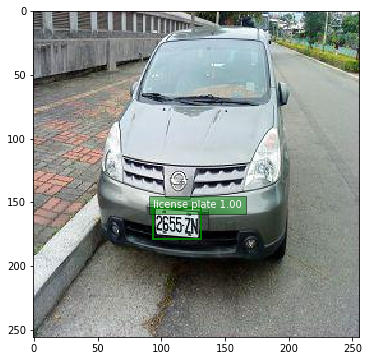

In [21]:
x, im = process_image('data/test/license-plate-071.jpg')
out = predict(x.as_in_context(ctx))
#out.shape
#out
display(im, out[0], threshold=0.8)

# Metrics

In [ ]:
train_data, class_names, num_class = get_test_iter(data_shape, batch_size)
metric_map = gluoncv.utils.metrics.VOC07MApMetric(iou_thresh=0.3)
gt_difficults = nd.zeros(shape=(32, 8))

for batch in train_data:
    output = predict(batch.data[0].as_in_context(ctx))
    pred_bboxes = output[:, :, 2:]
    pred_labels = output[:, :, 0]
    pred_scores = output[:, :, 1]
    gt_bboxes = batch.label[0][:, :, 1:]
    gt_labels = batch.label[0][:, :, 0]
    metric_map.update(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels, gt_difficults)
    
metric_map.get()

In [ ]:
train_data, class_names, num_class = get_test_iter(data_shape, batch_size)
metric_map = gluoncv.utils.metrics.VOC07MApMetric(iou_thresh=0.5)
gt_difficults = nd.zeros(shape=(32, 8))

for batch in train_data:
    output = predict(batch.data[0].as_in_context(ctx))
    pred_bboxes = output[:, :, 2:]
    pred_labels = output[:, :, 0]
    pred_scores = output[:, :, 1]
    gt_bboxes = batch.label[0][:, :, 1:]
    gt_labels = batch.label[0][:, :, 0]
    metric_map.update(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels, gt_difficults)
    
metric_map.get()

In [ ]:
train_data, class_names, num_class = get_test_iter(data_shape, batch_size)
metric_map = gluoncv.utils.metrics.VOC07MApMetric(iou_thresh=0.7)
gt_difficults = nd.zeros(shape=(32, 8))

for batch in train_data:
    output = predict(batch.data[0].as_in_context(ctx))
    pred_bboxes = output[:, :, 2:]
    pred_labels = output[:, :, 0]
    pred_scores = output[:, :, 1]
    gt_bboxes = batch.label[0][:, :, 1:]
    gt_labels = batch.label[0][:, :, 0]
    metric_map.update(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels, gt_difficults)
    
metric_map.get()

# Real time detection

In [ ]:

cap = cv2.VideoCapture('data/source/test091.mp4')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        x = process_video_frame(frame)
        out = predict(x.as_in_context(ctx))
        frame = add_bbox(frame, out[0], threshold=0.9)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()